In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
complexity_by_hour = pd.read_csv('complexity_by_hour.csv')
complexity_by_hour['hourly_time'] = pd.to_datetime(complexity_by_hour['hourly_time'])

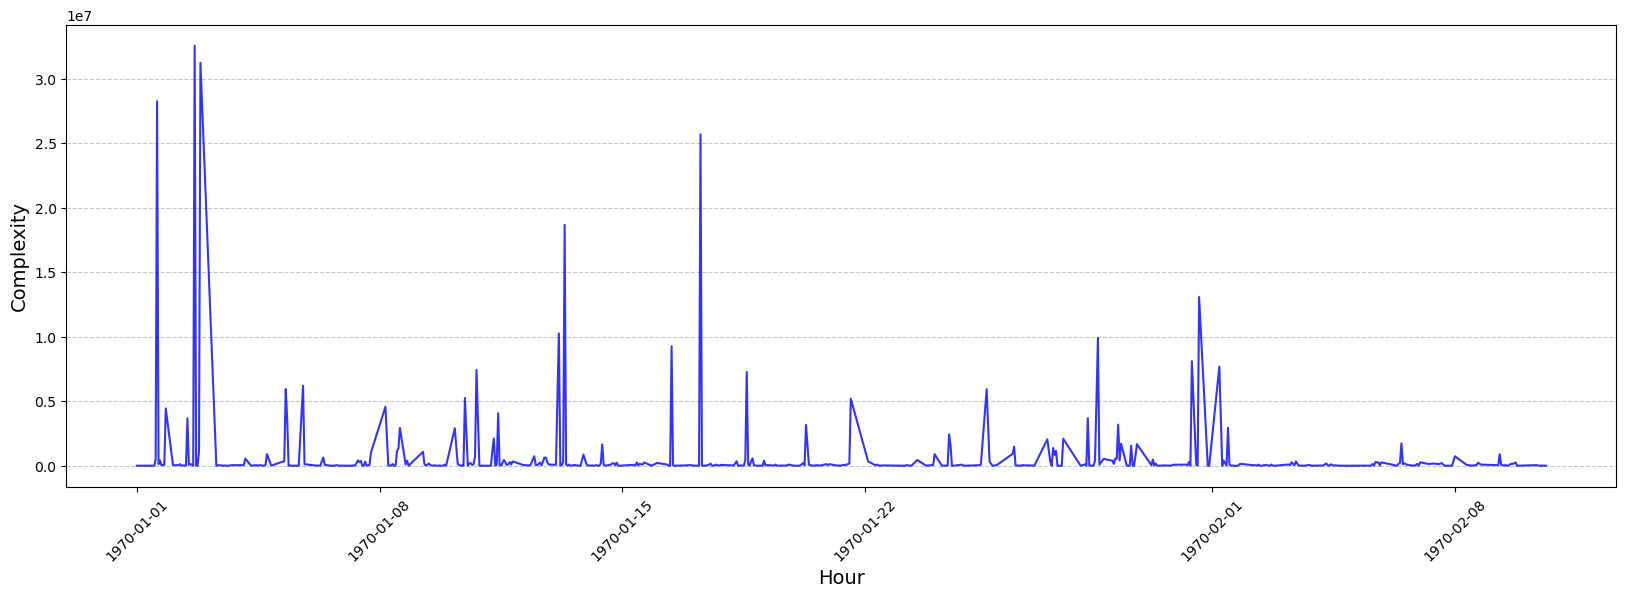

In [3]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(complexity_by_hour['hourly_time'][:500], complexity_by_hour['task_complexity'][:500], color='blue', alpha=0.8)

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Complexity', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for readability
plt.show()


In [8]:
SEQ_LENGTH = 60
TRAIN_RATE = 0.9
BATCH_SIZE = 1024

In [6]:
def create_sequences(data, SEQ_LENGTH):
    sequences = []
    labels = []
    for i in range(len(data) - SEQ_LENGTH):
        sequences.append(data[i:i+SEQ_LENGTH])  # Collect sequences
        labels.append(data[i+SEQ_LENGTH])      # Collect labels
    
    # Convert to tensors
    X = torch.Tensor(np.array(sequences)) # Shape: (num_samples, SEQ_LENGTH)
    y = torch.Tensor(np.array(labels))  # Shape: (num_samples)
    
    # Reshape X to have 3 dimensions: (batch_size, SEQ_LENGTH, input_size)
    X = X.view(X.shape[0], X.shape[1], 1)  # input_size = 1 feature per time step
    
    # Reshape y to have 2 dimensions: (batch_size, output_size)
    y = y.view(-1, 1)  # output_size = 1 target value
    
    return X, y

In [9]:
X, y = create_sequences(complexity_by_hour['task_complexity'], SEQ_LENGTH)

In [10]:
train_size = int(len(X) * 0.9)

scaler = StandardScaler()

train_scaled = scaler.fit_transform(complexity_by_hour[['task_complexity']][:train_size])
test_scaled = scaler.transform(complexity_by_hour[['task_complexity']][train_size:])

X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH)

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=2, dropout=0):
        super(LSTMModel, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass the input through the LSTM
        lstm_out, _ = self.lstm(x)

        # We only want the output of the last timestep, hence lstm_out[:, -1, :]
        last_timestep_out = lstm_out[:, -1, :]

        # Pass it through the fully connected layer
        out = self.fc(last_timestep_out)
        return out

    def fit(self, X, y, num_epochs, batch_size, criterion, optimizer, scheduler=None):
      self.to(self.device)
      train_data = TensorDataset(X, y)
      train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

      best_loss = np.inf
      best_state_dict = None

      for epoch in range(num_epochs):
          self.train()
          total_loss = 0  # Accumulate loss over batches

          # Iterate over the DataLoader
          for X_batch, y_batch in train_loader:
              # Move data to the specified device
              X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

              # Forward pass
              outputs = self(X_batch)

              # Calculate loss
              loss = criterion(outputs, y_batch)

              # Backward pass and optimization
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              # Accumulate batch loss
              total_loss += loss.item()

          # Calculate average loss for the epoch
          avg_loss = total_loss / len(train_loader)

          if avg_loss < best_loss:
              best_loss = avg_loss
              best_state_dict = self.state_dict()

          if scheduler is not None:
              scheduler.step(avg_loss)

          # Print loss at intervals
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

      if best_state_dict is not None:
          self.load_state_dict(best_state_dict)
          print(f"Returned best model with average loss: {best_loss}")

    def predict(self, X, batch_size=1024):
        data_loader = DataLoader(X, batch_size=batch_size, shuffle=False)
        predictions = []
        self.to(self.device)

        with torch.no_grad():
          # Iterate over the DataLoader
          for X_batch in data_loader:
              output_batch = self(X_batch.to(self.device))
              predictions.append(output_batch.cpu().numpy())

        return np.concatenate(predictions, axis=0)

In [16]:
model = LSTMModel(input_size=1, hidden_size=128, output_size=1, num_layers=3, dropout=0.2)

In [ ]:
model.fit(X=X_train, 
          y=y_train, 
          num_epochs=100, 
          batch_size=1024, 
          criterion=nn.MSELoss(), 
          optimizer=torch.optim.Adam(model.parameters(), lr=0.001))

In [35]:
y_pred = model.predict(X_train)

In [20]:
model.load_state_dict(torch.load(r"best_lstm.pth"))

<All keys matched successfully>